# Training data for restnet model 

In [2]:
#import libraries
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [3]:
# Dataset directories
train_dir = 'augmented data/training'
val_dir = 'augmented data/validation'

# Image size and batch size
img_size = (150, 150)  # Resize to match input requirements of ResNet
batch_size = 16  # Adjustable based on system memory

# ImageDataGenerator for data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 2240 images belonging to 2 classes.
Found 560 images belonging to 2 classes.


# using the RestNet model

In [8]:
# Load pre-trained ResNet50 without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling instead of flattening
x = Dense(128, activation='relu')(x)  # Custom dense layer
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 135s 1us/step


In [9]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [10]:
# Train the model
epochs = 10  # Set epochs based on hardware limitations
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)


Epoch 1/10


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


140/140 ━━━━━━━━━━━━━━━━━━━━ 90s 589ms/step - accuracy: 0.5451 - loss: 0.6919 - val_accuracy: 0.5411 - val_loss: 0.6776
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 85s 600ms/step - accuracy: 0.5948 - loss: 0.6794 - val_accuracy: 0.6446 - val_loss: 0.6634
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 108s 771ms/step - accuracy: 0.5934 - loss: 0.6757 - val_accuracy: 0.6714 - val_loss: 0.6541
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 125s 888ms/step - accuracy: 0.6263 - loss: 0.6634 - val_accuracy: 0.6232 - val_loss: 0.6462
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 117s 824ms/step - accuracy: 0.6111 - loss: 0.6590 - val_accuracy: 0.6875 - val_loss: 0.6382
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 113s 805ms/step - accuracy: 0.6261 - loss: 0.6586 - val_accuracy: 0.6607 - val_loss: 0.6317
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 114s 811ms/step - accuracy: 0.6200 - loss: 0.6537 - val_accuracy: 0.6839 - val_loss: 0.6284
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 579ms/step - accuracy: 0.6543 - loss: 0.6542 

In [11]:
# Save the trained model
model.save('models/resnet_brain_tumor.h5')

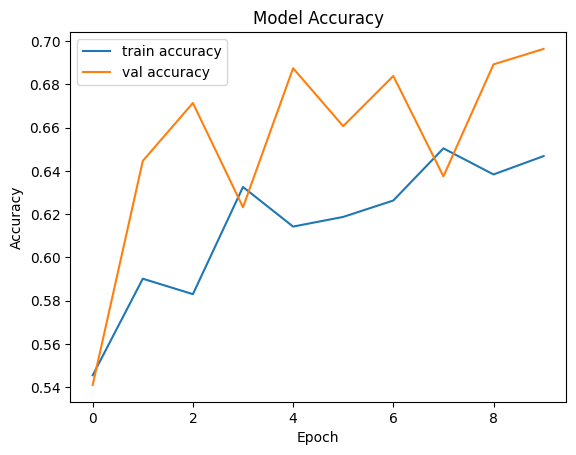

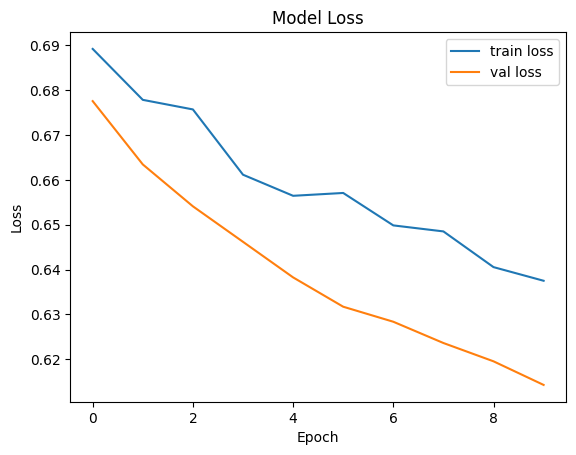

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [14]:
# Get true labels and predicted labels from the validation generator
val_generator.reset()  # Reset validation generator for consistent results
predictions = model.predict(val_generator, verbose=1)

# Convert predictions to binary labels (0 or 1)
predicted_classes = np.where(predictions > 0.5, 1, 0)

# Get true labels from the generator
true_classes = val_generator.classes

# Labels for the confusion matrix
class_labels = list(val_generator.class_indices.keys())


35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 439ms/step


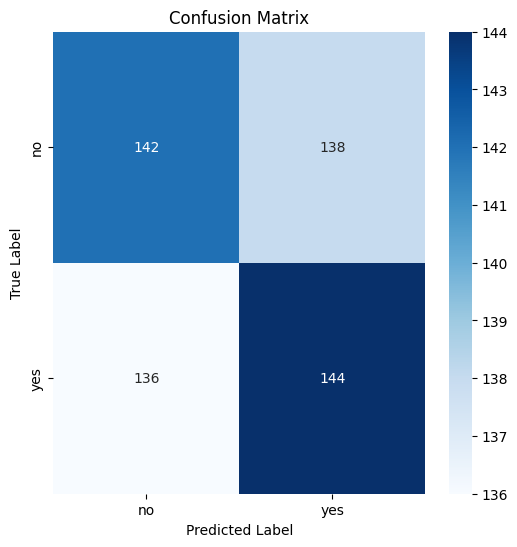

In [15]:
# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [16]:
# Print classification report for more details (precision, recall, f1-score)
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


              precision    recall  f1-score   support

          no       0.51      0.51      0.51       280
         yes       0.51      0.51      0.51       280

    accuracy                           0.51       560
   macro avg       0.51      0.51      0.51       560
weighted avg       0.51      0.51      0.51       560

